In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import pickle
import numpy as np

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data')

W1012 15:10:15.932987 140515517925184 deprecation.py:323] From <ipython-input-2-a4cb33905eda>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1012 15:10:15.935228 140515517925184 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1012 15:10:15.937424 140515517925184 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a futur

Extracting ./MNIST_data/train-images-idx3-ubyte.gz


W1012 15:10:16.495494 140515517925184 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W1012 15:10:16.595852 140515517925184 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


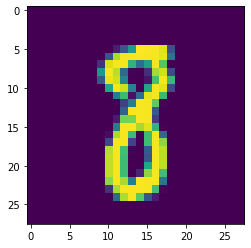

In [3]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28,28)))

In [4]:
def get_inputs(real_size,noise_size):
    real_img = tf.placeholder(tf.float32,[None,real_size],name='real_img')
    noise_img = tf.placeholder(tf.float32,[None,noise_size],name='noise_img')
    return real_img,noise_img

In [5]:
def get_generator(noise_img,n_units,out_dim,reuse=False,alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为32*32=784
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        hidden1 = tf.layers.dense(noise_img,n_units)
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden1 = tf.layers.dropout(hidden1,rate=0.2)
        logits = tf.layers.dense(hidden1,out_dim)
        outputs = tf.tanh(logits)
        return logits,outputs
    

In [6]:
def get_discriminator(img,n_units,reuse=False,alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    with tf.variable_scope("discriminator",reuse=reuse):
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        logits = tf.layers.dense(hidden1,1)
        output = tf.sigmoid(logits)
        
        return logits,output

In [7]:
# 定义参数
# 真实图像的size
img_size = mnist.train.images[0].shape[0]
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 128
# 判别器隐层参数
d_units = 128
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

In [8]:
tf.reset_default_graph()
real_img,noise_img = get_inputs(img_size,noise_size)
g_logits,g_outputs = get_generator(noise_img,g_units,img_size)
d_logits_real,d_outputs_real = get_discriminator(real_img,d_units)
d_logits_fake,d_outputs_fake = get_discriminator(g_outputs,d_units,reuse=True)

W1012 15:10:18.078345 140515517925184 deprecation.py:323] From <ipython-input-5-3d9eed7ca00f>:11: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W1012 15:10:18.085557 140515517925184 deprecation.py:506] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1012 15:10:18.662477 140515517925184 deprecation.py:323] From <ipython-input-5-3d9eed7ca00f>:13: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


In [9]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real))*(1-smooth))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
d_loss = tf.add(d_loss_real, d_loss_fake)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake))*(1-smooth))

W1012 15:10:18.867858 140515517925184 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
train_vars = tf.trainable_variables()
g_vars = [var for var in train_vars if var.name.startswith("generator")]
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [11]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            batch_images=batch[0].reshape(batch_size,784)
            batch_images = batch_images*2-1
            batch_noise = np.random.uniform(-1,1,size=(batch_size,noise_size))
            
            _ = sess.run(d_train_opt,feed_dict={real_img:batch_images,noise_img:batch_noise})
            _ = sess.run(g_train_opt,feed_dict={noise_img:batch_noise})
            
        train_loss_d = sess.run(d_loss,feed_dict={real_img:batch_images,noise_img:batch_noise})
        train_loss_d_real = sess.run(d_loss_real,feed_dict={real_img:batch_images,noise_img:batch_noise})
        train_loss_d_fake = sess.run(d_loss_fake,feed_dict={real_img:batch_images,noise_img:batch_noise})
        train_loss_g = sess.run(g_loss,feed_dict={noise_img:batch_noise})
        
        print("Epochs{}/{}...".format(e+1,epochs),
              "Discriminator loss: {:.4f}(Real:{:.4f}+Fake:{:.4f})...".format(train_loss_d,train_loss_d_real,train_loss_d_fake),
              "Generator loss:{:.4f}".format(train_loss_g))
        losses.append((train_loss_d,train_loss_d_real,train_loss_d_fake,train_loss_g))
        sample_noise = np.random.uniform(-1,1,size=(n_sample,noise_size))
        gen_samples = sess.run(get_generator(noise_img,g_units,img_size,reuse=True),
                               feed_dict={noise_img:sample_noise})
        samples.append(gen_samples)
        saver.save(sess,'./checkpoints/generator.ckpt')

Epochs1/300... Discriminator loss: 0.0596(Real:0.0321+Fake:0.0275)... Generator loss:4.5210
Epochs2/300... Discriminator loss: 0.2471(Real:0.1927+Fake:0.0544)... Generator loss:5.6942
Epochs3/300... Discriminator loss: 0.3978(Real:0.0403+Fake:0.3575)... Generator loss:2.6966
Epochs4/300... Discriminator loss: 1.1612(Real:0.8340+Fake:0.3272)... Generator loss:1.8065
Epochs5/300... Discriminator loss: 0.2894(Real:0.1737+Fake:0.1157)... Generator loss:2.6861
Epochs6/300... Discriminator loss: 0.7105(Real:0.3562+Fake:0.3543)... Generator loss:2.8398
Epochs7/300... Discriminator loss: 1.1021(Real:0.5771+Fake:0.5249)... Generator loss:1.7555
Epochs8/300... Discriminator loss: 0.5222(Real:0.2523+Fake:0.2699)... Generator loss:2.4362
Epochs9/300... Discriminator loss: 0.8017(Real:0.2662+Fake:0.5355)... Generator loss:1.9866
Epochs10/300... Discriminator loss: 1.4440(Real:1.2189+Fake:0.2251)... Generator loss:3.5426
Epochs11/300... Discriminator loss: 0.7911(Real:0.3849+Fake:0.4062)... Generato

Epochs90/300... Discriminator loss: 0.7988(Real:0.3079+Fake:0.4908)... Generator loss:1.2731
Epochs91/300... Discriminator loss: 0.9291(Real:0.6095+Fake:0.3195)... Generator loss:1.7180
Epochs92/300... Discriminator loss: 0.8123(Real:0.3315+Fake:0.4809)... Generator loss:1.2492
Epochs93/300... Discriminator loss: 0.8597(Real:0.3780+Fake:0.4818)... Generator loss:1.3787
Epochs94/300... Discriminator loss: 0.8887(Real:0.5629+Fake:0.3258)... Generator loss:1.6254
Epochs95/300... Discriminator loss: 0.7826(Real:0.4213+Fake:0.3613)... Generator loss:1.6617
Epochs96/300... Discriminator loss: 0.9841(Real:0.5495+Fake:0.4347)... Generator loss:1.4050
Epochs97/300... Discriminator loss: 1.0584(Real:0.7027+Fake:0.3557)... Generator loss:1.6982
Epochs98/300... Discriminator loss: 0.8818(Real:0.5089+Fake:0.3730)... Generator loss:1.5902
Epochs99/300... Discriminator loss: 0.9582(Real:0.5734+Fake:0.3848)... Generator loss:1.5479
Epochs100/300... Discriminator loss: 0.8890(Real:0.4780+Fake:0.4110)..

Epochs178/300... Discriminator loss: 0.7940(Real:0.4557+Fake:0.3382)... Generator loss:1.8134
Epochs179/300... Discriminator loss: 0.9128(Real:0.4040+Fake:0.5088)... Generator loss:1.4054
Epochs180/300... Discriminator loss: 0.7198(Real:0.3825+Fake:0.3373)... Generator loss:1.9383
Epochs181/300... Discriminator loss: 1.0093(Real:0.4308+Fake:0.5785)... Generator loss:1.1326
Epochs182/300... Discriminator loss: 0.8428(Real:0.4185+Fake:0.4243)... Generator loss:1.5252
Epochs183/300... Discriminator loss: 0.9322(Real:0.5826+Fake:0.3496)... Generator loss:1.7699
Epochs184/300... Discriminator loss: 1.0573(Real:0.6381+Fake:0.4192)... Generator loss:1.7709
Epochs185/300... Discriminator loss: 0.8037(Real:0.4081+Fake:0.3955)... Generator loss:1.4354
Epochs186/300... Discriminator loss: 0.9262(Real:0.4545+Fake:0.4717)... Generator loss:1.4883
Epochs187/300... Discriminator loss: 0.7844(Real:0.4369+Fake:0.3475)... Generator loss:1.6269
Epochs188/300... Discriminator loss: 0.8657(Real:0.3594+Fake

Epochs266/300... Discriminator loss: 0.7261(Real:0.3135+Fake:0.4126)... Generator loss:1.4901
Epochs267/300... Discriminator loss: 0.8020(Real:0.3146+Fake:0.4874)... Generator loss:1.3303
Epochs268/300... Discriminator loss: 0.7788(Real:0.4313+Fake:0.3475)... Generator loss:1.6322
Epochs269/300... Discriminator loss: 0.8892(Real:0.4684+Fake:0.4209)... Generator loss:1.6912
Epochs270/300... Discriminator loss: 0.8282(Real:0.3389+Fake:0.4893)... Generator loss:1.4480
Epochs271/300... Discriminator loss: 0.9480(Real:0.3984+Fake:0.5495)... Generator loss:1.5754
Epochs272/300... Discriminator loss: 1.1858(Real:0.5007+Fake:0.6851)... Generator loss:1.1459
Epochs273/300... Discriminator loss: 0.8903(Real:0.4392+Fake:0.4510)... Generator loss:1.5636
Epochs274/300... Discriminator loss: 0.8771(Real:0.2534+Fake:0.6237)... Generator loss:1.2573
Epochs275/300... Discriminator loss: 0.7355(Real:0.3220+Fake:0.4135)... Generator loss:1.7034
Epochs276/300... Discriminator loss: 0.7436(Real:0.2585+Fake

In [13]:
with open('train_samples.pkl','wb') as f:
    pickle.dump(samples,f)

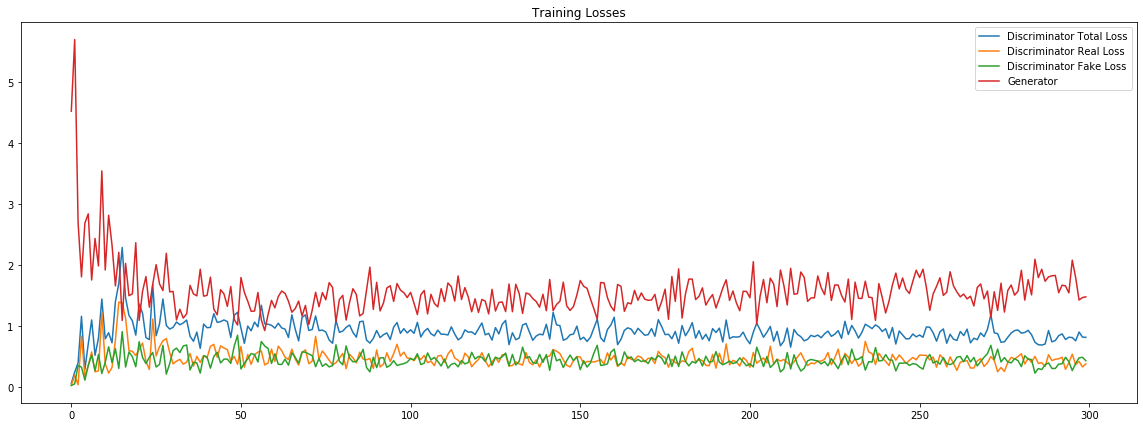

In [14]:
fig,ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0],label='Discriminator Total Loss')
plt.plot(losses.T[1],label='Discriminator Real Loss')
plt.plot(losses.T[2],label='Discriminator Fake Loss')
plt.plot(losses.T[3],label='Generator')
plt.title("Training Losses")
plt.legend()

In [15]:
with open ('train_samples.pkl','rb') as f:
    samples = pickle.load(f)

In [16]:
def view_samples(epoch,samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig,axes = plt.subplots(figsize=(7,7),nrows=5,ncols=5,sharey=True,sharex=True)
    for ax,img in zip(axes.flatten(),samples[epoch][1]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape(28,28))
    return fig, axes

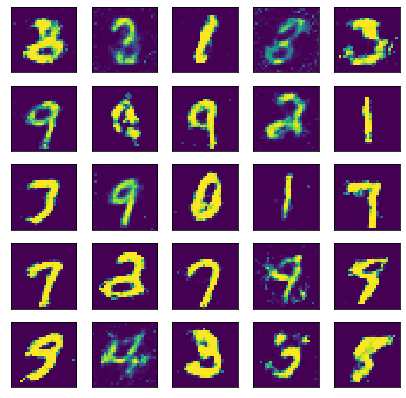

In [17]:
_ = view_samples(-1,samples)

In [18]:
epoch_idx = [0,5,10,20,40,60,80,100,150,250]
show_img = []
for i in epoch_idx:
    show_img.append(samples[i][1])

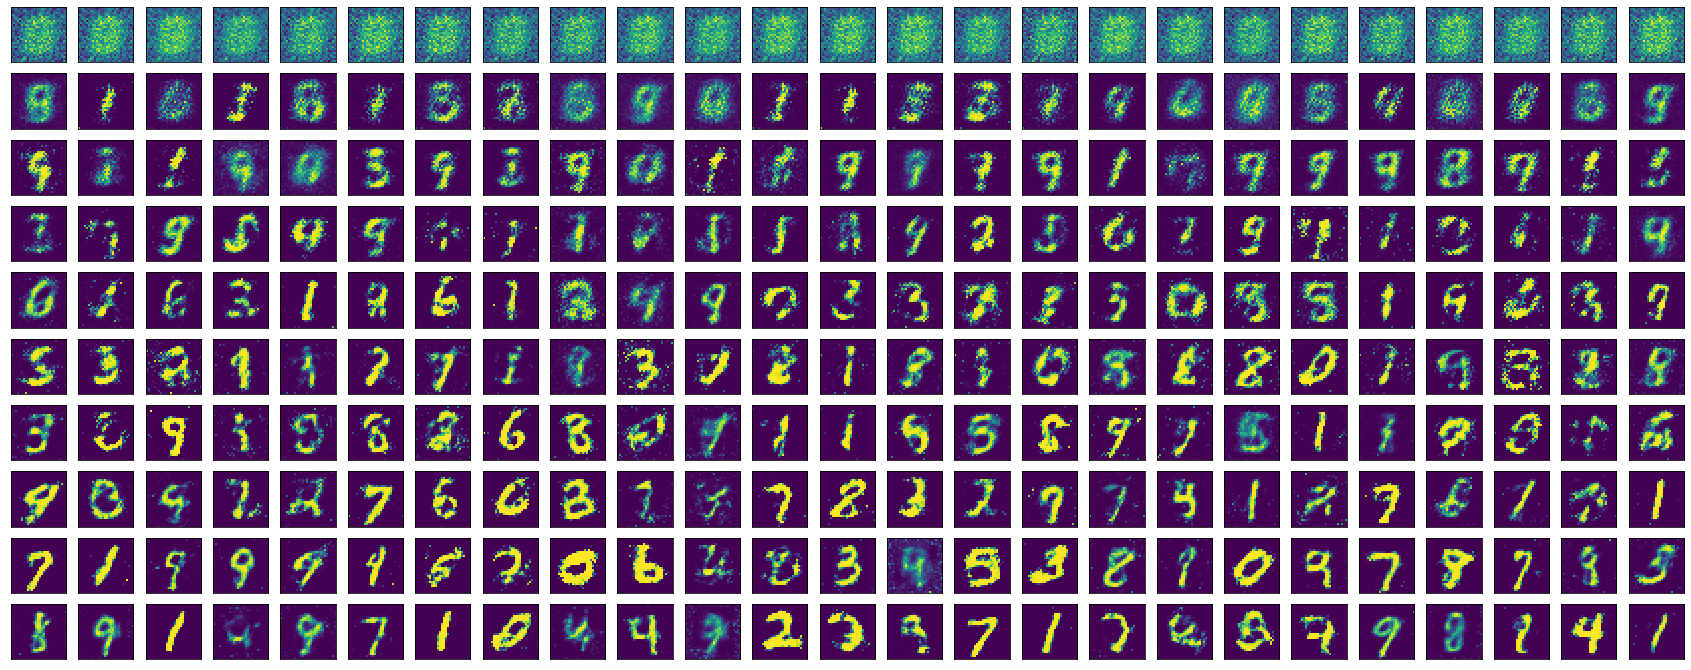

In [19]:
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))
for sample,ax_row in zip(show_img,axes):
    for img,ax in zip(sample[::int(len(sample)/cols)],ax_row):
        ax.imshow(img.reshape(28,28))
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [20]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess: 
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1,1,size=(25,noise_size))
    gen_samples = sess.run(get_generator(noise_img,g_units,img_size,reuse=True),
                           feed_dict={noise_img:sample_noise})
    

W1012 15:41:57.852920 140515517925184 deprecation.py:323] From /home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


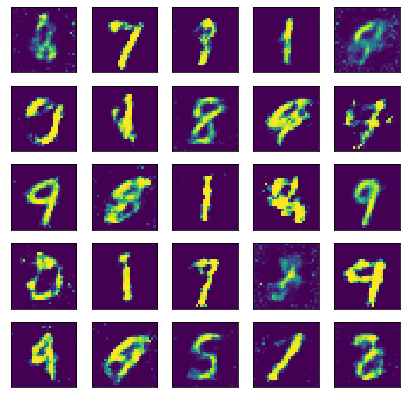

In [21]:
_ = view_samples(0,[gen_samples])